# 02 Regression: Homework

In [716]:
import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype
import seaborn as sns

In [717]:
df = pd.read_csv('laptops.csv')

In [718]:
df.head()

,Laptop,Status,Brand,Model,CPU,RAM,Storage,Storage type,GPU,Screen,Touch,Final Price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,NaN,15.6,No,1009.00
1,Alurin Go Start Intel Celeron N4020/8GB/256GB ...,New,Alurin,Go,Intel Celeron,8,256,SSD,NaN,15.6,No,299.00
2,ASUS ExpertBook B1 B1502CBA-EJ0424X Intel Core...,New,Asus,ExpertBook,Intel Core i3,8,256,SSD,NaN,15.6,No,789.00
3,MSI Katana GF66 12UC-082XES Intel Core i7-1270...,New,MSI,Katana,Intel Core i7,16,1000,SSD,RTX 3050,15.6,No,1199.00
4,HP 15S-FQ5085NS Intel Core i5-1235U/16GB/512GB...,New,HP,15S,Intel Core i5,16,512,SSD,NaN,15.6,No,669.01


## Data Preparation

In [719]:
def cleanColNames(df: pd.DataFrame) -> pd.DataFrame:
  df = df.copy()
  df.columns = df.columns.str.lower().str.replace(' ', '_')
  return df

In [720]:
def selectFeatures(df: pd.DataFrame, cols: list) -> pd.DataFrame:
  return df[cols]

In [721]:
model_inputs = ['ram', 'storage', 'screen', 'final_price']
df = cleanColNames(df)
df = selectFeatures(df, model_inputs)

In [722]:
def fillNullZero(df: pd.DataFrame) -> pd.DataFrame:
  df = df.copy()

  for col in df.columns:
   if is_numeric_dtype(df[col]):
     df[col] = df[col].fillna(0)
  
  return df

In [723]:
def fillNullMean(df: pd.DataFrame) -> pd.DataFrame:
  df = df.copy()

  for col in df.columns:
   if is_numeric_dtype(df[col]):
     df[col] = df[col].fillna(df[col].mean())
  
  return df

## Exploratory Data Aalysis

In [724]:
df.head()

,ram,storage,screen,final_price
0,8,512,15.6,1009.00
1,8,256,15.6,299.00
2,8,256,15.6,789.00
3,16,1000,15.6,1199.00
4,16,512,15.6,669.01


In [725]:
df.describe()

,ram,storage,screen,final_price
count,2160.000000,2160.000000,2156.000000,2160.000000
mean,15.413889,596.294444,15.168112,1312.638509
std,9.867815,361.220506,1.203329,911.475417
min,4.000000,0.000000,10.100000,201.050000
25%,8.000000,256.000000,14.000000,661.082500
50%,16.000000,512.000000,15.600000,1031.945000
75%,16.000000,1000.000000,15.600000,1708.970000
max,128.000000,4000.000000,18.000000,7150.470000


In [726]:
df.isna().sum()

ram            0
storage        0
screen         4
final_price    0
dtype: int64

In [727]:
df.ram.median()

16.0

<Axes: xlabel='final_price', ylabel='Count'>

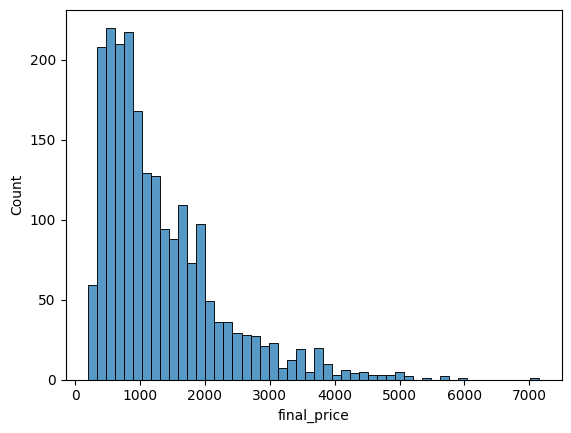

In [728]:
sns.histplot(df.final_price, bins=50)

## Model Input Preparation

In [729]:
def splitDataset(df: pd.DataFrame, cv_ratio, test_ratio, seed: int = 42) -> pd.DataFrame:
  n = df.shape[0]

  n_val = int(cv_ratio * n)
  n_test = int(test_ratio * n)
  n_train = n - (n_val + n_test)

  idx = list(df.index)

  np.random.seed(seed)
  np.random.shuffle(idx)

  df_train = df.iloc[idx[:n_train]].reset_index(drop=True)
  df_val = df.iloc[idx[n_train:n_train+n_val]].reset_index(drop=True)
  df_test = df.iloc[idx[n_train+n_val:]].reset_index(drop=True)

  return df_train, df_val, df_test

In [730]:
def featurePrep(df: pd.DataFrame, input_cols: list) -> np.array:
  df = df.copy()
  input_cols = input_cols.copy()

  # feature selection
  df = df[input_cols]

  # missing values
  df = fillNullMean(df)
  X = df.values

  return X
  

In [731]:
df_train, df_val, df_test = splitDataset(df, .2, .2)

In [732]:
base = ['ram', 'storage', 'screen']

In [733]:
X_train = featurePrep(df_train, base)
X_val = featurePrep(df_val, base)
X_test = featurePrep(df_test, base)

In [734]:
y_train = df_train['final_price']
y_val = df_val['final_price']
y_test = df_test['final_price']

# y_train = np.log1p(df_train['final_price'])
# y_val = np.log1p(df_val['final_price'])
# y_test = np.log1p(df_test['final_price'])

## Model Training

In [735]:
def trainLinearRegression(X: np.array, y: np.array) -> float:
  # add column for the bias
  ones = np.ones(X.shape[0])
  X = np.column_stack([ones, X])

  # compute optimal weights
  XTX = X.T.dot(X)
  XTX_inv = np.linalg.inv(XTX)
  w = XTX_inv.dot(X.T).dot(y)
  
  return w[0], w[1:]

In [736]:
def predictLog(X: np.array, b: np.array, w: np.array) -> float:
  return b + X.dot(w)

In [737]:
w0, w = trainLinearRegression(X_train, y_train)

In [738]:
pred_val = predictLog(X_val, w0, w)

<Axes: xlabel='final_price', ylabel='Count'>

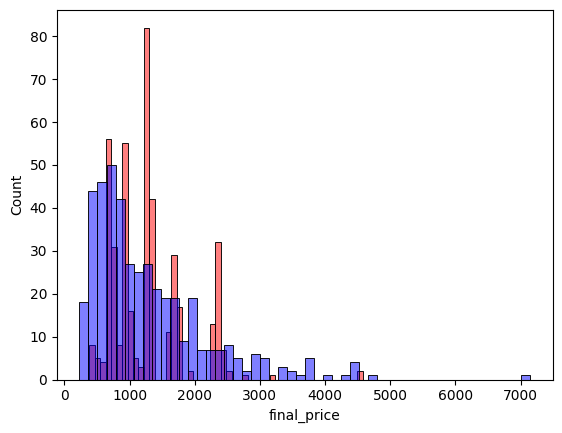

In [739]:
sns.histplot(pred_val, color='red', alpha=.5, bins=50)
sns.histplot(y_val, color='blue', alpha=.5, bins=50)

## Model Evaluation

In [740]:
def predRMSE(y_true: np.array, y_pred: np.array) -> float:
  error = y_true - y_pred
  squared_error = np.square(error)
  mse = squared_error.mean()
  rmse = np.sqrt(mse)

  return round(rmse, 2)

In [741]:
# fill mean
predRMSE(y_val, pred_val)

600.26

In [715]:
# fill zero
predRMSE(y_val, pred_val)

597.36

In [742]:
# actual values: zero model is better
# log transform: zero model is better

## Regularized Model

In [743]:
def featurePrep(df: pd.DataFrame, input_cols: list) -> np.array:
  df = df.copy()
  input_cols = input_cols.copy()

  # feature selection
  df = df[input_cols]

  # missing values
  df = fillNullZero(df)
  X = df.values

  return X

In [744]:
def trainRegLinearRegression(X: np.array, y: np.array, r: float =.01) -> float:
  # add column for the bias
  ones = np.ones(X.shape[0])
  X = np.column_stack([ones, X])

  # compute optimal weights
  XTX = X.T.dot(X)
  XTX += r * np.eye(XTX.shape[0]) # regularization
  XTX_inv = np.linalg.inv(XTX)
  w = XTX_inv.dot(X.T).dot(y)
  
  return w[0], w[1:]

In [745]:
X_train = featurePrep(df_train, base)
X_val = featurePrep(df_val, base)
X_test = featurePrep(df_test, base)

In [746]:
y_train = df_train['final_price']
y_val = df_val['final_price']
y_test = df_test['final_price']

In [747]:
r_vals = [0, 0.01, 0.1, 1, 5, 10, 100]

for r in r_vals:
  w0, w = trainRegLinearRegression(X_train, y_train, r)
  pred_val = predictLog(X_val, w0, w)
  err = predRMSE(y_val, pred_val)
  print(f'{r}: {err}')


0: 597.36
0.01: 597.36
0.1: 597.35
1: 597.21
5: 597.01
10: 597.06
100: 597.9


In [748]:
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
errs = np.array([])
for seed in seeds:
  df_train, df_val, df_test = splitDataset(df, .2, .2, seed)

  X_train = featurePrep(df_train, base)
  X_val = featurePrep(df_val, base)
  X_test = featurePrep(df_test, base)

  y_train = df_train['final_price']
  y_val = df_val['final_price']
  y_test = df_test['final_price']

  w0, w = trainLinearRegression(X_train, y_train)
  pred_val = predictLog(X_val, w0, w)
  err = predRMSE(y_val, pred_val)
  errs = np.append(errs, err)

In [749]:
errs.std()

29.176152950654732

## Model Testing

In [750]:
def featurePrep(df: pd.DataFrame, input_cols: list) -> np.array:
  df = df.copy()
  input_cols = input_cols.copy()

  # feature selection
  df = df[input_cols]

  # missing values
  df = fillNullZero(df)
  X = df.values

  return X

In [751]:
# split dataset
df_train, df_val, df_test = splitDataset(df, .2, .2, 9)
df_train_full = pd.concat([df_train, df_val])

# prepare features
X_train_full = featurePrep(df_train_full, base)
y_train_full = df_train_full['final_price']

# train model
w0, w = trainRegLinearRegression(X_train_full, y_train_full, 0.001)
pred_test = predictLog(X_test, w0, w)
err = predRMSE(y_test, pred_test)
err

608.61